# Ансамбль деревьев

В данном ноутбуке рассмотрим работу бэггинга над решающими деревьями, случайного леса и линейной комбинации разных алгоримов.

Для начала загрузим данные и посмотрим на них. 

In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

ds = datasets.load_diabetes()


In [2]:
ds.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [3]:
print(ds['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [4]:
print (ds.target)

[151.  75. 141. 206. 135.  97. 138.  63. 110. 310. 101.  69. 179. 185.
 118. 171. 166. 144.  97. 168.  68.  49.  68. 245. 184. 202. 137.  85.
 131. 283. 129.  59. 341.  87.  65. 102. 265. 276. 252.  90. 100.  55.
  61.  92. 259.  53. 190. 142.  75. 142. 155. 225.  59. 104. 182. 128.
  52.  37. 170. 170.  61. 144.  52. 128.  71. 163. 150.  97. 160. 178.
  48. 270. 202. 111.  85.  42. 170. 200. 252. 113. 143.  51.  52. 210.
  65. 141.  55. 134.  42. 111.  98. 164.  48.  96.  90. 162. 150. 279.
  92.  83. 128. 102. 302. 198.  95.  53. 134. 144. 232.  81. 104.  59.
 246. 297. 258. 229. 275. 281. 179. 200. 200. 173. 180.  84. 121. 161.
  99. 109. 115. 268. 274. 158. 107.  83. 103. 272.  85. 280. 336. 281.
 118. 317. 235.  60. 174. 259. 178. 128.  96. 126. 288.  88. 292.  71.
 197. 186.  25.  84.  96. 195.  53. 217. 172. 131. 214.  59.  70. 220.
 268. 152.  47.  74. 295. 101. 151. 127. 237. 225.  81. 151. 107.  64.
 138. 185. 265. 101. 137. 143. 141.  79. 292. 178.  91. 116.  86. 122.
  72. 

Разделим данные на обучающую и тестовую часть.

In [5]:
X = ds.data
Y = ds.target
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)

### 1. Решающее дерево

Построим одно решающее дерево по обучающей выборке. Будем использовать гиперпараметры по умолчанию. Это значит, что мы никак не будем использовать регуляризацию для дерева (ограничивать глубину и число листьев).

In [6]:
from sklearn.tree import DecisionTreeRegressor

In [7]:
clf = DecisionTreeRegressor()

In [8]:
clf.fit(X_train, y_train)

DecisionTreeRegressor()

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
mean_squared_error(y_test, clf.predict(X_test))

5622.89592760181

In [11]:
mean_squared_error(y_train, clf.predict(X_train))

0.0

MSE на обучающей выборке равно нулю. Построенное дерево переобучилось и не ошиблось ни на одном объекте из обучения.

### 2. Бэггинг над решающими деревьями

In [61]:
res = np.zeros(X_test.shape[0]) #сюда кладём сумму предсказаний всех алгоритмов. Но сначала там вектор из нулей, 
#размер = число объектов в тестовой части
N = 100 #- количество алгоритмов
clf = DecisionTreeRegressor()
for i in range(N): 
    ind = np.random.choice(np.arange(X_train.shape[0]),
                           size = X_train.shape[0], replace = True)
    clf.fit(X_train[ind], y_train[ind])
    res += clf.predict(X_test)

In [62]:
mean_squared_error(y_test, res/N) #качество бэггинга лучше одного решающего дерева.

3313.4770411764707

Как известно из лекций решающее дерево без регуляризации имеет большой разброс и маленькое смещение.
Бэггинг уменьшает разброс алгоритма, поэтому ошибка бэггинга меньше, чем ошибка одного решающего дерева.

Попробуем помимо случайных объектов в подвыборках выбирать и случайные признаки. То есть каждое дерево обучать не на всех признаках, а на случайном подмножестве признаков.

In [57]:
res = np.zeros(X_test.shape[0])
N = 100
clf = DecisionTreeRegressor()
for i in range(N):
    ind = np.random.choice(np.arange(X_train.shape[0]), # выбираем индексы объектов
                           size = X_train.shape[0], replace = True)
    ind_feat = np.random.choice(np.arange(X_train.shape[1]), #Выбираем случайные признаки, без повторений
                           size = round(X_train.shape[1]*0.2))
    clf.fit(X_train[ind][:, ind_feat], y_train[ind])
    res += clf.predict(X_test[:, ind_feat])

In [58]:
mean_squared_error(y_test, res/N)

4390.505291368247

Качество стало заметно хуже.

### 3. Случайный лес

Случайный лес помимо бэггинга над деревьями использует метод случайных подпространств. При построении разбиения в каждой вершине каждого дерева используются не все признаки, а лишь случайное подмножество призкаков. Это необходимо, чтобы ответы на построенных деревьях меньше коррелировали между собой.

In [63]:
from sklearn.ensemble import RandomForestRegressor

In [64]:
clf = RandomForestRegressor(n_estimators=100, max_features=0.2)

In [65]:
clf.fit(X_train, y_train)

RandomForestRegressor(max_features=0.2)

In [66]:
mean_squared_error(y_test, clf.predict(X_test))

3416.216540271493

### 4. Зависимость качества от числа деревьев 

In [20]:
import matplotlib.pyplot as plt

In [21]:
Q = [] # сюда будем складывать качество по MSE
for n_est in range(1, 200, 2):
    clf = RandomForestRegressor(n_estimators=n_est, max_features=0.2)
    clf.fit(X_train, y_train)
    Q.append(mean_squared_error(y_test, clf.predict(X_test)))


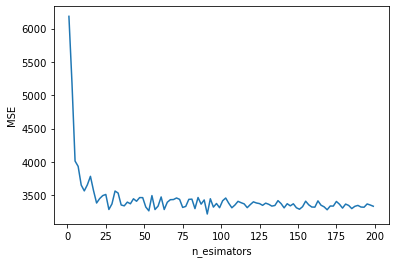

In [22]:
plt.plot(range(1, 200, 2), Q)
plt.xlabel('n_esimators')
plt.ylabel('MSE')
plt.show()

### 5. Зависимость качества от гиперпарамерта max_features (отвечает за то, какоекол-во признаков будем перебирать для выбора лучшего разбиения в каждой вершине)

In [69]:
Q = []
for max_feat in range(1, 10):
    clf = RandomForestRegressor(n_estimators=100, max_features=max_feat)
    clf.fit(X_train, y_train)
    Q.append(mean_squared_error(y_test, clf.predict(X_test)))


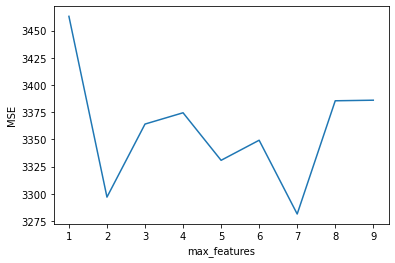

In [70]:
plt.plot(range(1, 10), Q)
plt.xlabel('max_features')
plt.ylabel('MSE')
plt.show()

## 6. Важность признаков

In [25]:
import seaborn as sns
import pandas as pd

In [26]:
feature_imp = pd.DataFrame({'importances': clf.feature_importances_, 'name':ds.feature_names})

<AxesSubplot:xlabel='importances', ylabel='name'>

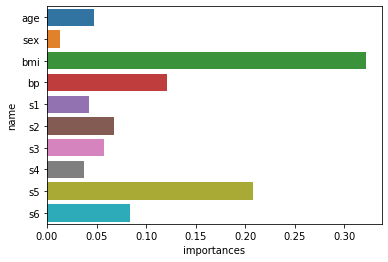

In [27]:
sns.barplot(x="importances", y="name", data=feature_imp)

Наиболее важные признаки при обучении случайного леса оказались

`bmi` - Body mass index

`s5`

Удалим один из наиболее важных признаков



In [28]:
ds.feature_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [29]:
ind = np.append(np.arange(2), np.arange(3, 10))

In [30]:
clf = RandomForestRegressor(n_estimators=100, max_features=0.2)

In [31]:
clf.fit(X_train[:, ind], y_train)

RandomForestRegressor(max_features=0.2)

In [32]:
mean_squared_error(y_test, clf.predict(X_test[:, ind]))

3768.1518357466066

Удалим наименее важный признак

In [33]:
ind = np.append(np.arange(1), np.arange(2, 10))

In [34]:
clf.fit(X_train[:, ind], y_train)

RandomForestRegressor(max_features=0.2)

In [35]:
mean_squared_error(y_test, clf.predict(X_test[:, ind]))

3612.976153846154

Видно, что при удалении важных признаков MSE сильно возрастает. При удалении наименее важных признаков MSE почти не изменяется.

## 7. Смешивание моделей

Часто с помощью линейной комбинации разных моделей можно добиться лучшего качества, чем с помощью каждой модели по отдельности.


Используем линейную комбинацию 

In [36]:
from sklearn.linear_model  import LinearRegression

In [37]:
lr = LinearRegression()

In [38]:
lr.fit(X_train,  y_train)

LinearRegression()

In [39]:
mean_squared_error(y_test, lr.predict(X_test))

3359.499466288206

In [40]:
clf = RandomForestRegressor(n_estimators=200)
clf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [41]:
min_mse = mean_squared_error(y_test, lr.predict(X_test))
for i in range(100):
    mse = mean_squared_error(y_test, 
                           (i*lr.predict(X_test) + (100 - i)*clf.predict(X_test))/100.0)
    if mse < min_mse:
        min_mse = mse
        best_i = i

In [42]:
mean_squared_error(y_test, 
                   (best_i*lr.predict(X_test) + (100 - best_i)*clf.predict(X_test))/100.0)

3201.0007881449064